In [ ]:
# imports and setup
import pandas as pd
import numpy as np
import nltk
import stanza
import re
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# regex cleaning pattern
pattern = r'[^A-Za-z0-9]+'

In [ ]:
# import corpora
stanza.download('en')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

In [ ]:
# initialise nlp pipeline
nlp = stanza.Pipeline()
sid = SentimentIntensityAnalyzer()

In [ ]:
# define some plot colours
colors = ['#142459', '#176BA0', '#19AADE', '#1AC9E6', '#1DE4BD', '#60F0D2', '#c7F9EE']

In [ ]:
# read data from csv
reviews = pd.read_csv('data/Books_rating.csv')

In [ ]:
# check first n rows of review text
reviews[['review/text', 'review/score']].iloc[:10]

In [ ]:
# set number of rows to sample and default maximum number of aspects:
n = 100
aspects = 8

In [ ]:
# lowercase and tokenise
data = reviews[['review/text', 'review/score']].iloc[:n].apply(lambda x: x.astype(str).str.lower())
sentence_tokenized = data['review/text'].apply(nltk.sent_tokenize)

In [ ]:
# define sentence cleaning, tokenization and parts of speech tagging function
def clean_sentence(sentence):
    clean_sentence = re.sub(pattern, ' ', sentence)
    token_clean = nltk.word_tokenize(clean_sentence)
    pos_clean = nltk.pos_tag(token_clean)
    return(pos_clean, clean_sentence, token_clean)

In [ ]:
# clean and tokenize data
review_list = []
for review in sentence_tokenized:
    sentence_clean = []
    sentence_pos = []
    sentence_token = []
    for sentence in review:
        pos, clean, token = clean_sentence(sentence)
        sentence_pos.append(pos)
        sentence_clean.append(clean)
        sentence_token.append(token)
    review_dict = {"sentence": sentence_clean, "token": sentence_token, "pos": sentence_pos}
    review_list.append(review_dict)

In [ ]:
# put tokenized data in dataframe
tokenized_data = pd.DataFrame(review_list)   
tokenized_data['scores'] = None
tokenized_data['duration'] = 0
tokenized_data = pd.concat([tokenized_data, data['review/score']], axis=1, join='inner')
tokenized_data.head()

In [ ]:
# sentiment score calculator using nltk's Sentiment Analyzer
def sentiment_score(finalcluster):
    scores = []
    for pair in finalcluster:
        # only look at valid pairs
        if len(pair[1]) != 0:
            score = sid.polarity_scores(''.join(pair[1]))
            if score['compound'] != 0.0:
                pair_score = [pair, score['compound']]
                scores.append(pair_score)
    return(scores)

In [ ]:
# given a sentence, find the dependencies
def find_relationships(doc, token, pos):
    # categories = []
    if doc.sentences[0].dependencies:
        dep_obj = []
        for dep in doc.sentences[0].dependencies:
            dep_obj.append([dep[2].text, dep[0].id, dep[1]])
        for item in range(0, len(dep_obj)):
            if (int(dep_obj[item][1]) != 0):
                dep_obj[item][1] = token[(int(dep_obj[item][1]) - 1)]
                
        # possible features if noun (NN, NNS), adjective (JJ, JJR) or adverb (RB)
        features = []
        for item in pos:
            # if(i[1]=='JJ' or i[1]=='NN' or i[1]=='JJR' or i[1]=='NNS' or i[1]=='RB'):
            if item[1] in ('RB', 'NNS', 'JJR', 'NN', 'JJ'):
                features.append(list(item))

        # cluster together features and descriptive words
        cluster = []
        for item in features:
            feature_list = []
            for i in dep_obj:
                if((item[0] in (i[0], i[1])) and (i[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                # if((i[0]==item[0] or i[1]==item[0]) and (i[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                    if(i[0]==item[0]):
                        feature_list.append(i[1])
                    else:
                        feature_list.append(i[0])
            cluster.append([item[0], feature_list])

        # select only nouns
        noun_cluster = []
        dict = {}
        for item in features:
            dict[item[0]] = item[1]
        for item in cluster:
            if(dict[item[0]]=="NN"):
                noun_cluster.append(item)

        # get sentence sentiment scores for all features (aspects) in cluster
        sentence_sentiment = sentiment_score(noun_cluster) 
    return(sentence_sentiment)

In [ ]:
# refine aspect outputs and scores formatting (untangle lists of lists of lists)
def get_aspects(scores):
    aspects = []
    for x in scores:
        for y in x:
            aspects.append([y[0][0], y[0][1][0], y[1]])
    return(aspects)

In [ ]:
# perform absa on given data, with chosen aspect limit and number of samples
def absa(tokenized_data, aspects = aspects, n = n):
    # loop through data
    #review level
    for i in tqdm(range(0, n)):
        start_review = time.time()
        current_aspects = 0
        # sentence level
        review_scores = []
        for j in range(0, len(tokenized_data['sentence'].loc[i]) - 1):
            current_aspects = len(review_scores)
            if current_aspects >= aspects:
                continue
            sentence = tokenized_data['sentence'].loc[i][j]
            pos = tokenized_data['pos'].loc[i][j]
            token = tokenized_data['token'].loc[i][j] 
            if len(sentence.strip()) == 0:
                continue
            else:
                doc = nlp(sentence)
                try:
                    scores = find_relationships(doc, token, pos)
                    if len(scores) != 0:
                        review_scores.append(scores)
                except:
                    continue

            # limit number of aspects processed
        tokenized_data['scores'].iloc[i] = review_scores[0:aspects]     
        duration = time.time() - start_review
        tokenized_data['duration'].loc[i] = duration  
    return(tokenized_data.iloc[:n])

In [ ]:
# classify review based on aspect sentiment scores
def predict(scores):
    prediction = None
    prediction_sum = 0
    for x in scores:
        prediction_sum += float(x[2])
        if prediction_sum > 0:
            prediction = 'Positive'
        elif prediction_sum < 0:
            prediction = 'Negative'
        else:
            prediction = 'Neutral'
    return(prediction)

In [ ]:
# format and measure output and print to csv
def measure(output, n, aspects):
    try:
        output['review/score'] = output['review/score'].apply(lambda x: int(x.replace('.0', '')))
    except:
        print('already converted to int!')
    output['label'] = np.where(output['review/score'] >= 3, 'Positive', 'Negative')
    output['label'] = np.where(output['review/score'] == 3, 'Neutral', output['label'])
    try:
        output['scores'] = output['scores'].apply(get_aspects)
    except:
        print('aspects already found!')
    output['prediction'] = output['scores'].apply(predict)
    output['correct'] = np.where(output['label'] == output['prediction'], 1, 0)
    if aspects < 10:
        output.to_csv('output/0' + str(aspects) + 'output(n' + str(n) + '_a' + str(aspects) + ').csv')
    else:
        output.to_csv('output/' + str(aspects) + 'output(n' + str(n) + '_a' + str(aspects) + ').csv')
    return(output)

In [ ]:
# perform absa for each aspect limit in list (overrides default aspect) and save the output. The full list takes a while to be processed.
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]:
    a = i
    print('n =', n, 'a =', a)
    output = absa(tokenized_data = tokenized_data, aspects = a, n = n)
    measure(output, n, a)
print('done!')

In [27]:
# read output into comparitive time_series and percentage of correct predictions
time_series = pd.DataFrame(columns = ['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20'])
# correct = pd.DataFrame(columns = ['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20'])
correct = []
a = 1
for filename in os.listdir('output/'):
    print(a, filename)
    output_file = pd.read_csv('output/' + filename)
    series = output_file['duration'].cumsum()
    column = 'a=' + str(a)
    time_series[column] = series
    correct.append(output_file['correct'].sum()/73)
    if a< 10:
        a += 1
    else:
        a += 5


1 01output(n100_a1).csv
2 02output(n100_a2).csv
3 03output(n100_a3).csv
4 04output(n100_a4).csv
5 05output(n100_a5).csv
6 06output(n100_a6).csv
7 07output(n100_a7).csv
8 08output(n100_a8).csv
9 09output(n100_a9).csv
10 10output(n100_a10).csv
15 15output(n100_a15).csv
20 20output(n100_a20).csv


In [28]:
time_series

,a=1,a=2,a=3,a=4,a=5,a=6,a=7,a=8,a=9,a=10,a=15,a=20
0,0.144999,0.118001,0.118001,0.121000,0.127000,0.134001,0.126999,0.128000,0.131000,0.124000,0.122999,0.128999
1,2.157000,2.952001,2.933001,2.882001,2.912001,3.064005,3.079001,3.117001,3.131002,3.129001,3.189001,3.097001
2,3.098000,4.054002,6.210003,6.621004,6.389003,6.941005,7.010003,7.189003,7.115003,7.074002,7.048002,7.048003
3,7.697001,9.528004,12.357006,12.860007,12.699007,13.505009,13.486006,14.151005,14.136005,13.871006,13.516005,13.507006
4,11.036004,12.829006,15.633513,16.173008,15.957009,16.696010,16.719007,17.791007,17.593007,17.112007,16.756007,16.835009
...,...,...,...,...,...,...,...,...,...,...,...,...
95,79.336000,117.103023,140.742914,148.064075,149.613090,152.702083,155.773295,157.104156,159.037041,157.490174,159.360586,159.690088
96,79.685000,118.423024,142.421915,149.769076,151.248090,154.300084,157.448296,158.807159,160.672043,159.087174,161.031588,161.338088
97,79.952002,118.677024,142.691914,149.997076,151.584091,154.529085,157.668296,159.035157,160.898043,159.316175,161.259587,161.600090
98,81.985001,122.860027,147.229917,154.417077,155.794091,158.870087,162.020297,163.367160,165.339045,163.716177,165.684591,166.049090


In [29]:
correct

[0.7397260273972602,
 0.726027397260274,
 0.726027397260274,
 0.726027397260274,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466]

In [30]:
columns = ['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20']
time_series.loc[99].index[0]
time_series.loc[99].values[0]


83.43900227546692

Text(100, 168.51209259033203, 'a=20')

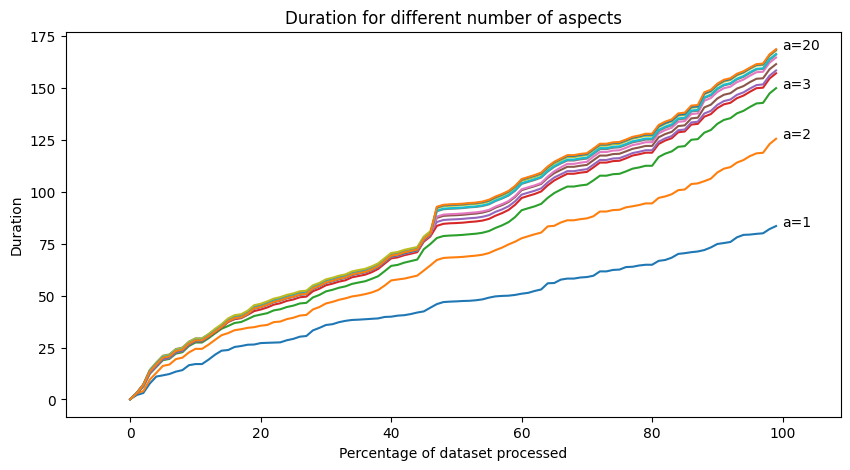

In [31]:
# Time series of daily reviews
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_series)
ax.set_ylabel('Duration')
ax.set_xlabel('Percentage of dataset processed')
ax.set_title('Duration for different number of aspects')
ax.margins(x=0.1)
for i in range(0, 3):
    plt.text(100, time_series.loc[99].values[i], time_series.loc[99].index[i])
# plt.text(100, time_series.loc[99].values[9], time_series.loc[99].index[9])
plt.text(100, time_series.loc[99].values[11], time_series.loc[99].index[11])


In [32]:
# get number of aspects per review
aspect_length= []
aspect_df = pd.DataFrame(columns = ['aspects'])
for i in range(0, len(output['scores'])):
    aspect_length.append(len(output['scores'].loc[i]))
aspect_df['aspects'] = aspect_length
aspect_df['aspects'].head()

0    1
1    2
2    3
3    4
4    1
Name: aspects, dtype: int64

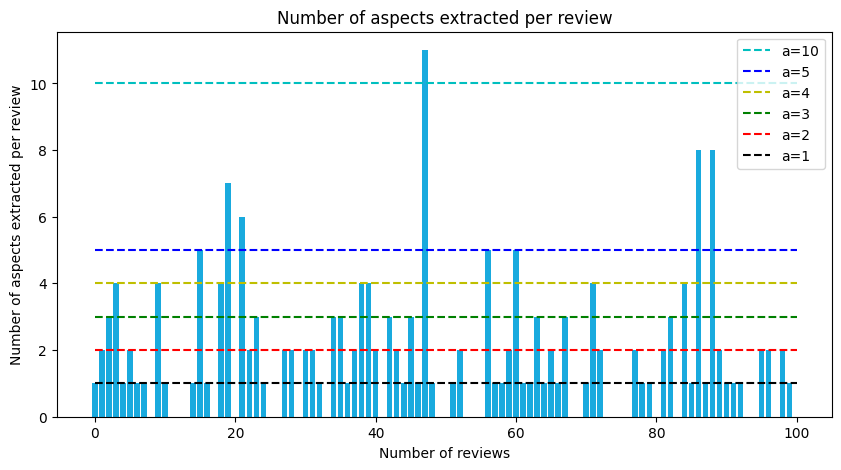

In [33]:
# plot aspects per review. Make sure that the last asba model run was for a = 20 to show all possible aspects
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(aspect_df.index, aspect_df['aspects'], color = colors[2])
ax.set_ylabel('Number of aspects extracted per review')
ax.set_xlabel('Number of reviews')
ax.set_title('Number of aspects extracted per review')
line10, = ax.plot([0, 100], [10, 10], "c--", label = 'a=10')
line5, = ax.plot([0, 100], [5, 5], "b--", label = 'a=5')
line4, = ax.plot([0, 100], [4, 4], "y--", label = 'a=4')
line3, = ax.plot([0, 100], [3, 3], "g--", label = 'a=3')
line2, = ax.plot([0, 100], [2, 2], "r--", label = 'a=2')
line1, = ax.plot([0, 100], [1, 1], "k--", label = 'a=1')
line1.set_label('a=1')
line2.set_label('a=2')
line3.set_label('a=3')
line4.set_label('a=4')
line5.set_label('a=5')
line10.set_label('a=10')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Percentage of correct sentiment classifications per number of allowed aspects (a)')

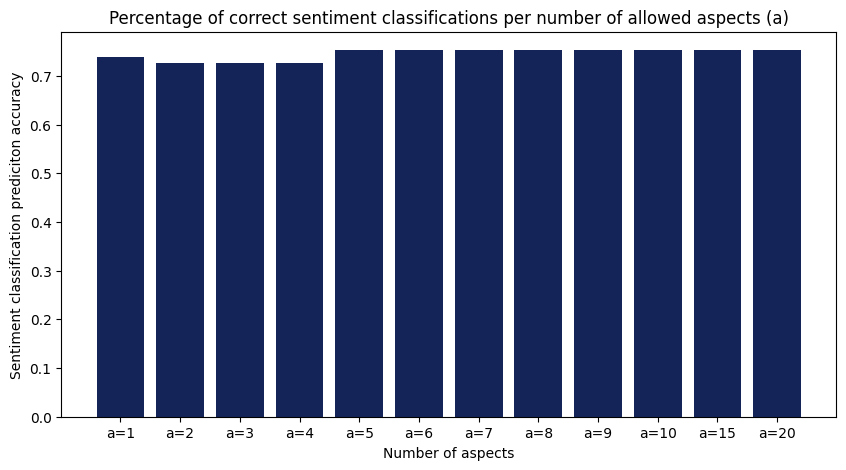

In [34]:
# prediction accuracy
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20'], correct, color = colors[0])
ax.set_ylabel('Sentiment classification prediciton accuracy')
ax.set_xlabel('Number of aspects')
ax.set_title('Percentage of correct sentiment classifications per number of allowed aspects (a)')